In [23]:
import os
import mne
import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FS_subjects_dir = os.path.join('D:\\', 'freesurfer', 'subjects')
MEG_subjects_dir = os.path.join('D:\\', 'RSVP_data', 'processed_data')
Subject_ids = 'S{id:02d}'

D:\RSVP_data\processed_data\MEG_S04\RSVP_MRI_S04-src.fif


C:\Users\liste\Anaconda3\lib\site-packages\mne\viz\misc.py:307: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = nim.get_data()


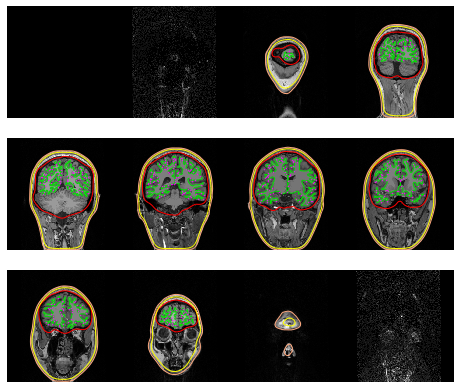

Done.
D:\RSVP_data\processed_data\MEG_S04\RSVP_MRI_S04-bem.fif
Done.
D:\RSVP_data\processed_data\MEG_S04\RSVP_MRI_S04-bem-sol.fif
Done.


(<SourceSpaces: [<surface (lh), n_vertices=152260, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=152545, n_used=4098, coordinate_frame=MRI (surface RAS)>]>,
 [{'id': 4,
   'sigma': 0.30000001192092896,
   'np': 2562,
   'ntri': 5120,
   'coord_frame': array([5]),
   'rr': array([[-1.91135507e-03, -1.00820828e-02,  1.07663669e-01],
          [ 7.37979710e-02, -1.00494763e-02,  6.15703873e-02],
          [ 2.27982774e-02,  6.52587637e-02,  6.25305325e-02],
          ...,
          [ 1.07954917e-02,  1.05241966e-02, -1.27658576e-01],
          [ 5.78555337e-05,  1.39856590e-02, -1.27753168e-01],
          [ 2.54520262e-03,  3.64431413e-03, -1.27315879e-01]]),
   'nn': array([[-1.4197640e-05,  1.3890559e-18,  1.0000000e+00],
          [ 8.9454746e-01,  0.0000000e+00,  4.4697300e-01],
          [ 2.7644274e-01,  8.5070127e-01,  4.4708699e-01],
          ...,
          [ 9.0630502e-02,  1.4721242e-01, -9.8494399e-01],
          [ 1.3215269e-02,  1.7234801e-01, -

In [3]:
sid = Subject_ids.format(id=4)
FS_subject = 'RSVP_MRI_{}'.format(sid)
MEG_subject = os.path.join(MEG_subjects_dir, 'MEG_{}'.format(sid))

show = True
spacing = 'oct6'

# Source space
tmppath = os.path.join(MEG_subject, '{}-src.fif'.format(FS_subject))
print(tmppath)
if os.path.exists(tmppath):
    src = mne.read_source_spaces(tmppath)
else:
    src = mne.setup_source_space(subject=FS_subject, spacing=spacing,
                                 subjects_dir=FS_subjects_dir)
    mne.write_source_spaces(tmppath, src)
# print(src)

mne.viz.plot_bem(subject=FS_subject, subjects_dir=FS_subjects_dir,
                 src=src,
                 brain_surfaces='white', orientation='coronal',
                 show=show)
print('Done.')

# BEM surfaces
tmppath = os.path.join(MEG_subject, '{}-bem.fif'.format(FS_subject))
print(tmppath)
if os.path.exists(tmppath):
    model = mne.read_bem_surfaces(tmppath)
else:
    model = mne.make_bem_model(subject=FS_subject, subjects_dir=FS_subjects_dir)
    mne.write_bem_surfaces(tmppath, model)
# print(model)
print('Done.')

# BEM solution
tmppath = os.path.join(MEG_subject, '{}-bem-sol.fif'.format(FS_subject))
print(tmppath)
if os.path.exists(tmppath):
    bem_sol = mne.read_bem_solution(tmppath)
else:
    bem_sol = mne.make_bem_solution(model)
    mne.write_bem_solution(tmppath, bem_sol)
# print(bem_sol)
print('Done.')

src, model, bem_sol

In [4]:
trans_fif_path = os.path.join(MEG_subjects_dir, MEG_subject, '{}-trans.fif'.format(FS_subject))
raw_fif_paths = [os.path.join(MEG_subjects_dir, MEG_subject, e) for e in os.listdir(MEG_subject) if e.endswith('_ica-raw.fif')]

In [5]:
iter_freqs = [
    ('Delta', 1, 4),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
#     ('Gamma', 30, 45),
    ('Cb_U04', 0.1, 4),
    ('Cb_U07', 0.1, 7),
    ('Cb_U12', 0.1, 12),
    ('Cb_U30', 0.1, 30),
]

tmin, tmax = -0.2, 1.2
picks = 'mag'
decim = 12

n_jobs = 10

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 114 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 291 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 301 out of 301 | elapsed:    8.3s finished
Index: 3750361: 100%|████████████████████████| 560/560 [00:23<00:00, 23.53it/s]


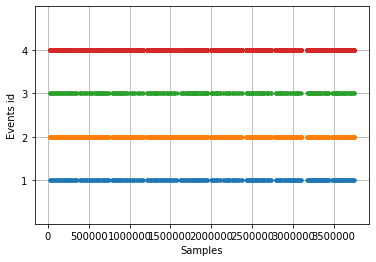

Done.
1


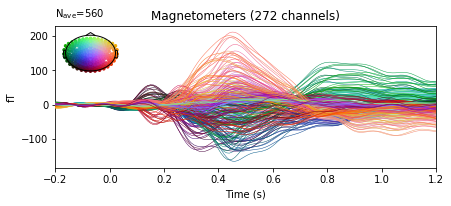

2


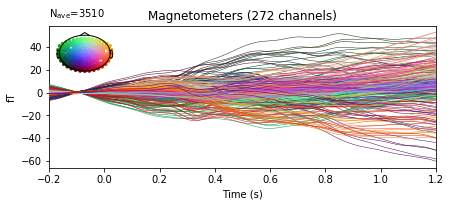

Done.


<Epochs  |   4070 events (all good), -0.2 - 1.2 sec, baseline [None, 0], ~1.16 GB, data loaded,
 '1': 560
 '2': 3510>

In [6]:
raws = mne.concatenate_raws([mne.io.read_raw_fif(e, verbose=0) for e in raw_fif_paths])
raws_raw = raws.copy()

raws.load_data()
l_freq, h_freq = 0.1, 7
raws.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)

events = mne.find_events(raws, stim_channel='UPPT001')
sfreq = raws.info['sfreq']
with tqdm.tqdm(events[events[:, -1]==1]) as pbar:
    for e in pbar:
        pbar.set_description('Index: {}'.format(e[0]))
        for ee in events:
            if all([ee[-1] == 2, abs(ee[0]-e[0])<sfreq]):
                ee[-1] = 4
mne.viz.plot_events(events)
print('Done.')

epochs = mne.Epochs(raws, events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
epochs = epochs[['1', '2']]
epochs.load_data()

for event in epochs.event_id:
    print(event)
    epochs[event].average().plot(spatial_colors=True)

print('Done.')
epochs

In [7]:
# Fwd: forward solution
fwd = mne.make_forward_solution(raws.info, trans_fif_path, src, bem_sol)

# Cov: noise_cov
# https://mne.tools/stable/auto_examples/inverse/plot_covariance_whitening_dspm.html#sphx-glr-auto-examples-inverse-plot-covariance-whitening-dspm-py
cov = mne.compute_covariance(epochs, method='shrunk', tmin=None, tmax=0, n_jobs=n_jobs)

# Inv: inverse_operation
inv = mne.minimum_norm.make_inverse_operator(raws.info, fwd, cov, loose='auto')

In [8]:
# https://mne.tools/stable/generated/mne.minimum_norm.apply_inverse.html#mne.minimum_norm.apply_inverse
stc = mne.minimum_norm.apply_inverse(epochs['1'].average(), inv, lambda2=0.1, return_residual=False)

# https://mne.tools/stable/generated/mne.minimum_norm.apply_inverse_epochs.html#mne.minimum_norm.apply_inverse_epochs
stcs = mne.minimum_norm.apply_inverse_epochs(epochs['1'], inv, lambda2=0.1)

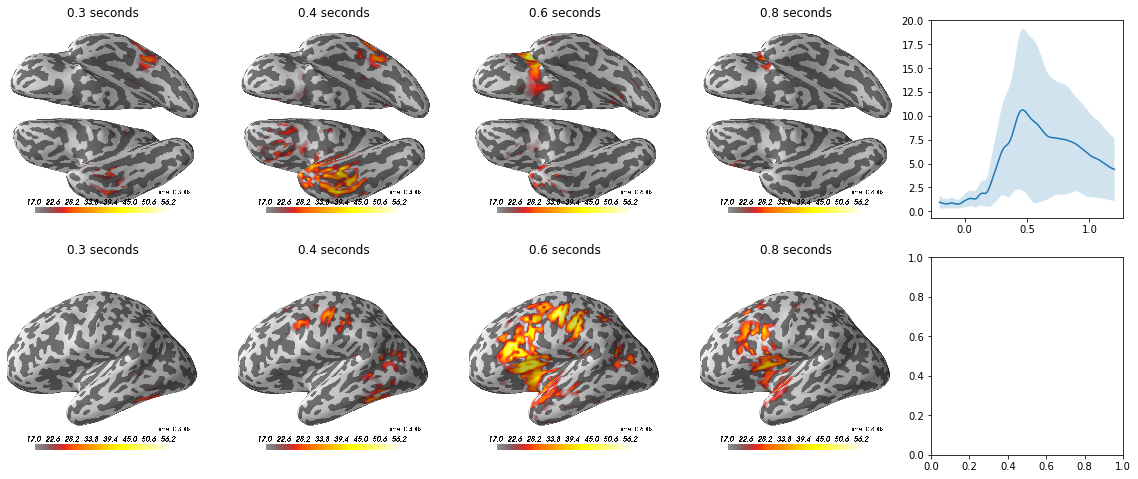

In [38]:
alldata = sorted(stc.data.ravel(), reverse=True)
n = len(alldata)
clim = dict(kind='value', lims=[alldata[int(n * r)] for r in [0.05, 0.01, 0]])

times = [0.3, 0.4, 0.6, 0.8]
fig, axes = plt.subplots(2, len(times)+1, figsize=((len(times)+1) * 4, 8))

stc_mean = stc.data.mean(0)
stc_var = stc.data.std(0)
ax = axes[0][-1]
ax.plot(stc.times, stc_mean)
ax.fill_between(stc.times, stc_mean - stc_var, stc_mean + stc_var, alpha=0.2)

for j, time in enumerate(times):
    brain = stc.plot(subjects_dir=FS_subjects_dir, hemi='both', clim=clim,
                     initial_time=time, background='w', foreground='k')
    
    im = []
    brain.show_view('ven')
    im.append(brain.screenshot())
    brain.show_view('med')
    im.append(brain.screenshot())
    brain.close()
    
    for i in range(2):
        ax = axes[i][j]
        ax.imshow(im[i])
        ax.axis('off')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('{} seconds'.format(time))

In [41]:
fig.savefig('a.png')